In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install permetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm
from permetrics.regression import RegressionMetric

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
#from keras.utils import plot_model
from tensorflow.keras.layers import InputLayer

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from sklearn.metrics import r2_score

#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## 데이터 불러오기, 공통 전처리

In [4]:
newdata5 = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/newdata5.csv', encoding = 'cp949')
df = newdata5[['방류량', '강화대교_조위']]
df['한강대교_유량'] = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/newdata7_한강대교_유량_광진교_제외.csv', encoding = 'cp949')
df['청담대교_유량'] = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/newdata7_청담대교_유량.csv', encoding = 'cp949')

# 광진수위, 행주유량, 수위4개 데이터셋 가져오고, 마지막 6912개 수위 데이터 replace
수위유량 = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/Copy of 0827 광진행주유량수위x4.csv', encoding = 'cp949')

In [5]:
수위유량.iloc[-6912:, [2, 3, 4, 5]] = newdata5.iloc[-6912:, [-4, -3, -2, -1]]

raw_data = pd.concat([df, 수위유량], axis = 1)
raw_data

,방류량,강화대교_조위,한강대교_유량,청담대교_유량,광진교_수위,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,575.70,193.0,729.80,469.05,1.20,540.18,310.7,300.2,290.0,275.3
1,575.30,199.0,731.48,498.00,1.20,540.18,314.7,300.2,290.0,275.3
2,555.00,207.0,726.42,490.68,1.20,540.18,313.7,301.2,290.0,275.3
3,575.70,215.0,726.42,476.21,1.20,552.17,311.7,301.2,290.0,276.3
4,575.40,226.0,707.17,476.21,1.20,564.29,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...
276331,258.67,407.0,-456.41,319.84,1.12,974.40,288.0,295.0,299.0,306.0
276332,258.58,431.0,-717.30,314.01,1.12,1006.88,287.0,303.0,304.0,308.0
276333,258.56,453.0,-843.37,387.55,1.12,1039.90,299.0,307.0,309.0,310.0
276334,258.65,476.0,-1023.37,454.91,1.12,1073.46,309.0,311.0,314.0,312.0


In [6]:
# x y 나누기
input_y = raw_data[['청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]
input_x = raw_data

# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = input_x.copy()

for i in range(len(input_x.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

input_regular = pd.concat([input_x_regular, input_y], axis = 1)
input_regular

,방류량,강화대교_조위,한강대교_유량,청담대교_유량,광진교_수위,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,0.058462,0.191781,0.147596,0.010523,0.056452,0.011070,0.049611,0.060000,0.051621,0.056478,310.7,300.2,290.0,275.3
1,0.058447,0.199253,0.147654,0.011862,0.056452,0.011070,0.053502,0.060000,0.051621,0.056478,314.7,300.2,290.0,275.3
2,0.057689,0.209215,0.147478,0.011523,0.056452,0.011070,0.052529,0.061111,0.051621,0.056478,313.7,301.2,290.0,275.3
3,0.058462,0.219178,0.147478,0.010854,0.056452,0.011475,0.050584,0.061111,0.051621,0.058140,311.7,301.2,290.0,276.3
4,0.058451,0.232877,0.146810,0.010854,0.056452,0.011883,0.050584,0.061111,0.052821,0.059801,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,0.046624,0.458281,0.106425,0.003624,0.045699,0.025719,0.027529,0.054222,0.062425,0.107475,288.0,295.0,299.0,306.0
276332,0.046621,0.488169,0.097370,0.003355,0.045699,0.026815,0.026556,0.063111,0.068427,0.110797,287.0,303.0,304.0,308.0
276333,0.046620,0.515567,0.092994,0.006755,0.045699,0.027929,0.038230,0.067556,0.074430,0.114120,299.0,307.0,309.0,310.0
276334,0.046624,0.544209,0.086747,0.009870,0.045699,0.029061,0.047957,0.072000,0.080432,0.117442,309.0,311.0,314.0,312.0


## train / test data 생성

In [7]:
xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-4,-3,-2,-1]
for i in range(len(input_regular.columns)-4):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

100%|██████████| 11/11 [04:21<00:00, 23.73s/it]


In [8]:
xdata_ = np.array(xdata)
ydata_ = np.array(ydata)

xtrain = xdata_[:-6912]
ytrain = ydata_[:-6912]
xtest = xdata_[-6912:]
ytest = ydata_[-6912:]

In [9]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(269358, 6, 10)
(269358, 4)
(6912, 6, 10)
(6912, 4)


## 모델 정의

In [10]:
def nse(y_true, y_pred):
    return (1-(K.sum((y_true-y_pred)**2)/K.sum((y_true-K.mean(y_true))**2)))

def root_mean_squared_error(y_true, y_pred):
    return (K.sqrt(K.mean(K.square(y_pred - y_true))))

if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(InputLayer(input_shape=(w, xtrain.shape[2])))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(BatchNormalization())
#model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(GRU(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(Dropout(0.5))
model_enc_dec_cnn.add(GRU(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(Dropout(0.5))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(GRU(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(4))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_enc_dec_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             1344      
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 384)           0         
 )                                                               
                                                                 
 gru (GRU)                   (None, 1, 200)            351600    
                                                                 
 dropout (Dropout)           (None, 1, 200)            0         
                                                                 
 gru_1 (GRU)                 (None, 1, 200)            241200    
                                                        

In [11]:
# plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [12]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=1e-10)

## 학습

In [13]:
history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
802/802 [==============================] - 53s 59ms/step - loss: 26.5716 - nse: 0.4899 - val_loss: 14.0060 - val_nse: 0.5895 - lr: 0.0100
Epoch 2/100
802/802 [==============================] - 44s 55ms/step - loss: 12.4756 - nse: 0.9489 - val_loss: 18.4666 - val_nse: -1.0380 - lr: 0.0100
Epoch 3/100
802/802 [==============================] - 45s 56ms/step - loss: 11.2699 - nse: 0.9584 - val_loss: 25.5040 - val_nse: -3.4164 - lr: 0.0100
Epoch 4/100
802/802 [==============================] - 43s 54ms/step - loss: 10.8250 - nse: 0.9617 - val_loss: 36.2181 - val_nse: -6.3616 - lr: 0.0100
Epoch 5/100
802/802 [==============================] - 46s 57ms/step - loss: 9.5435 - nse: 0.9701 - val_loss: 35.5171 - val_nse: -7.1838 - lr: 0.0050
Epoch 6/100
802/802 [==============================] - 43s 54ms/step - loss: 9.3763 - nse: 0.9711 - val_loss: 34.2443 - val_nse: -5.7744 - lr: 0.0050
Epoch 7/100
802/802 [==============================] - 45s 56ms/step - loss: 9.3193 - nse: 0.9715

## 평가

In [14]:
ytest_list = sorted(glob("/content/drive/MyDrive/신입기수 프로젝트/Dataset/submission 임시/*.csv"))
ytest = []

for i in range(len(ytest_list)):
  tmp = pd.read_csv(ytest_list[i], encoding = 'cp949')
  ytest.append(np.array(tmp.iloc[:,1])*100)
    
ytest_ = ytest
ytest = np.array(ytest).T

In [15]:
keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse': nse})

yhat = keras_model_best.predict(xtest, verbose=1)

keras_model_best.evaluate(xtest,ytest)

216/216 [==============================] - 2s 6ms/step - loss: 12.9110 - nse: 0.2172


[12.911015510559082, 0.21723002195358276]

## 학습 과정 시각화

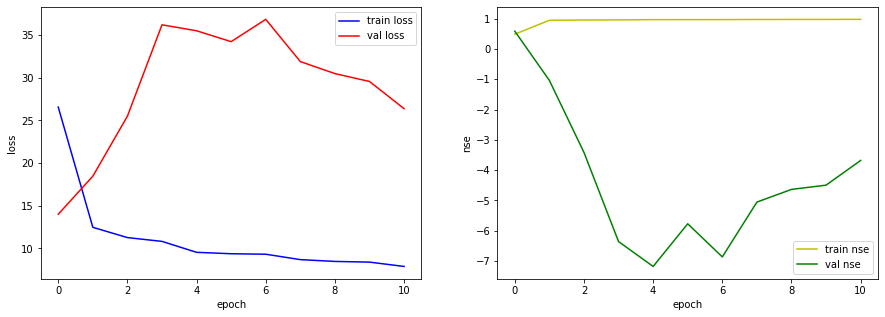

In [16]:
fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['nse'], 'y', label='train nse')
loss_ax[1].plot(history.history['val_nse'], 'g', label='val nse')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

## 결과 시각화

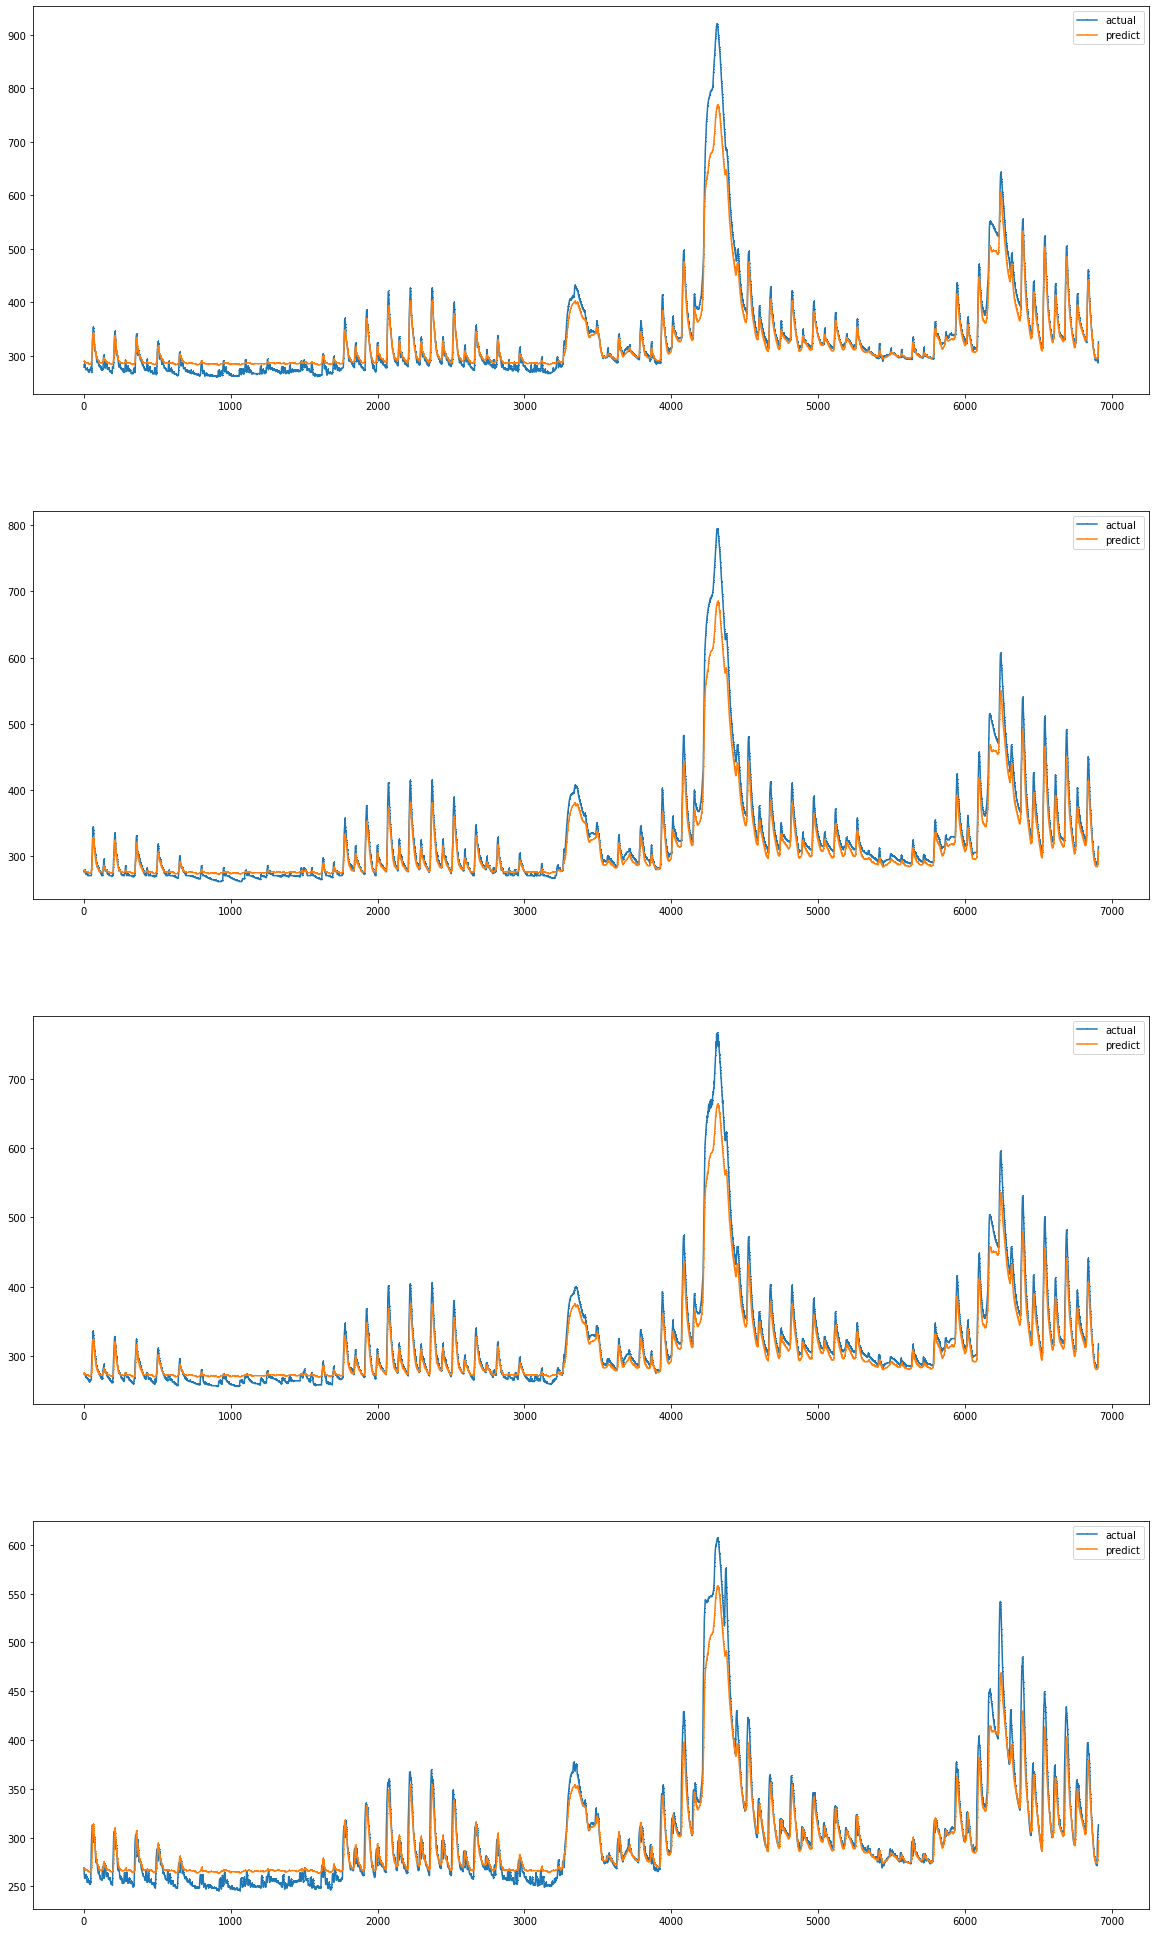

In [17]:
tl_predict = np.array(yhat).T

#결과 시각화
f, axes = plt.subplots(4, 1)
f.set_size_inches((20, 35))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(4):
    axes[i].plot(ytest_[i], marker = ",", label = "actual")
    axes[i].plot(tl_predict[i], marker = ",", label="predict")
    axes[i].legend(prop={'size':10})  

plt.show()

## 점수 확인

In [18]:
score = []
for i in range(4):
    print(root_mean_squared_error(ytest_[i], tl_predict[i])  / r2_score(ytest_[i], tl_predict[i]))
    score.append(root_mean_squared_error(ytest_[i], tl_predict[i]) / r2_score(ytest_[i], tl_predict[i]))
    
print("최종점수: ", np.mean(score))

tf.Tensor(22.91399689991449, shape=(), dtype=float64)
tf.Tensor(19.140314579040904, shape=(), dtype=float64)
tf.Tensor(18.198085830865733, shape=(), dtype=float64)
tf.Tensor(17.089720979925453, shape=(), dtype=float64)
최종점수:  19.33552957243665


## 파일 제출

In [19]:
sample_submission = pd.read_csv("/content/drive/MyDrive/신입기수 프로젝트/DACON/competition_data/sample_submission.csv")

sample_submission["wl_1018662"] = tl_predict[0]
sample_submission["wl_1018680"] = tl_predict[1]
sample_submission["wl_1018683"] = tl_predict[2]
sample_submission["wl_1019630"] = tl_predict[3]

sample_submission.to_csv("/content/drive/MyDrive/신입기수 프로젝트/Dataset/0828_newdata7.csv", index = False)

## 결과 해석

In [20]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 4.9 MB/s 
     |████████████████████████████████| 133 kB 46.7 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=5e6f991f696e1543cb5e9f1d8ef73e0a4e7d31f0a192230416cbec0e6fb1e501
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.


In [21]:
eli5.show_weights(keras_model_best)

NameError: ignored

In [ ]:
!pip install shap

In [ ]:
import shap
# SHAP model explainer
shap.initjs()

explainer = shap.DeepExplainer(keras_model_best, xtrain)
explainer

In [ ]:
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()

In [ ]:
shap_value = explainer.shap_values(xtest)

In [ ]:
shap_val = np.array(shap_value)

In [ ]:
a = np.absolute(shap_val[0])
b = np.sum(a, axis=1)
SHAP_list = [np.sum(b[:, 0]), np.sum(b[:, 1]), np.sum(b[:, 2]), np.sum(b[:, 3]), np.sum(b[:, 4])]
N_weight = normalize(weight_list)
N_SHAP = normalize(SHAP_list)